In [1]:
import scipy.io
import cv2
from BlockSync2 import *
import numpy as np
import pandas as pd
import scipy.io as io
import pathlib
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
from open_ephys import analysis as oea
import bokeh
from bokeh.io import output as b_output
from bokeh.models import formatters
import scipy.signal as sig
from scipy import stats as st
import scipy.interpolate as interp
import time
from scipy.stats import kde
from UtilityFunctions import *
import pickle

In [2]:
# Function definitions
def analyzed_block_automated_pipe(block):
    """This function runs all the import steps that I am already confident about for a block
    that has already gone through synchronization and dlc reading"""
    block.handle_eye_videos()
    block.handle_arena_files()
    block.parse_open_ephys_events()
    block.synchronize_arena_timestamps()
    block.create_arena_brightness_df(threshold_value=240,export=True)
    block.synchronize_block(export=True)
    block.create_eye_brightness_df(threshold_value=250)
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.saccade_event_analayzer(threshold=1.5,automatic=True)

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    """
    return np.isnan(y), lambda z: z.nonzero()[0]

def multi_block_saccade_dict_creation(blocklist, ep_channel=17):

    saccade_dict = {}
    # loop over the blocks from here:
    for block in blocklist:
        # collect accelerometer data
        # path definition
        p = block.oe_path / 'analysis'
        analysis_list = os.listdir(p)
        correct_analysis = [i for i in analysis_list if "PV_24" in i][0]
        p = p / str(correct_analysis)
        matPath = p / 'lizMov.mat'
        print(f'path to mat file is {matPath}')
        # read mat file
        matDict = io.loadmat(matPath)
        # df_dict = {'t_mov_ms':matDict['t_mov_ms'][0,:],
        #            'movAll':matDict['movAll'][0,:]}
        # df = pd.DataFrame.from_dict(df_dict)

        # The t_mov_ms column indicates the times when threshold-crossing movements occurred in Milliseconds from electrophysiology recording beginning
        # the movAll column gives the amplitude of said movements as a combination of the 3D accelerometer channels

        # It is now needed to synchronize the timebase so that 0 will be the beginning of synchronized time and not beginning of oe recording
        # first, find the very first timestamp of the oe recording
        session = oea.Session(str(block.oe_path.parent))
        rec_node = session.recordnodes[0].recordings[0].continuous[0]
        rec_starts = rec_node.timestamps[0]
        # second, find the first arena_TTL oe based timestamp
        sync_starts = block.final_sync_df.Arena_TTL[0]
        # t_mov_ms should have the Milliseconds between beginning of the recording and beginning of synchronized time subtracted to align 0 with the synctime 0
        delta_samples = sync_starts - rec_starts
        delta_samples_ms = (delta_samples / block.sample_rate)*1000
        synced_t_ms_mov = matDict['t_mov_ms'][0,:] - delta_samples_ms # correction happens here
        # now create the df and delete the dict
        df_dict = {'t_mov_ms': synced_t_ms_mov,
                   'movAll': matDict['movAll'][0,:]}
        acc_df = pd.DataFrame.from_dict(df_dict)
        del df_dict

        # collect saccade events
        block.saccade_event_analayzer(automatic=True,threshold=2)

        # get all the electrophysiology data of a single electrode:
        print(f'getting EP data from block {block.block_num}')
        #session = oea.Session(str(block.oe_path.parent))
        data = session.recordnodes[0].recordings[0].continuous[0].samples[:,ep_channel]
        timestamps = session.recordnodes[0].recordings[0].continuous[0].timestamps
        print('done')

        # create the top-level block dict object
        block_dict = {
            'L':{},
            'R':{}
        }

        # create and populate the internal dictionaries (for each eye)
        for i, e in enumerate(['L','R']):
            # get the correct saccades_chunked object and eye_df
            saccades_chunked = [block.l_saccades_chunked,block.r_saccades_chunked][i]
            eye_df = [block.le_df,block.re_df][i]
            saccades = saccades_chunked[saccades_chunked.saccade_length_frames > 0]
            saccade_times = np.sort(saccades.saccade_start_ms.values)
            saccade_ts = eye_df[eye_df['ms_axis'].isin(saccade_times)].Arena_TTL.values

            # now use the saccade_ts vector to choose samples with a given segment length before and after the saccades
            seg_seconds = 2
            segment_length = seg_seconds*block.sample_rate #samples
            before_saccade_ts = saccade_ts - segment_length
            after_saccade_ts = saccade_ts + segment_length

            # start populating the dictionary
            block_dict[e] = {
                "timestamps":[],
                "fs":[],
                "pxx":[],
                "samples":[],
                "x_coords":[],
                "y_coords":[],
                "vid_inds":[],
                "accel":[]
            }

            # go saccade by saccade
            for i in tqdm(range(len(saccade_ts))):

                # define the segment range
                pre_saccade_sample_ind = np.where(timestamps == int(before_saccade_ts[i]))[0][0]
                post_saccade_sample_ind = np.where(timestamps == int(after_saccade_ts[i]))[0][0]
                samples_range = range(pre_saccade_sample_ind,post_saccade_sample_ind)
                segment_samples = data[samples_range]

                # get the spectral profile for the segment
                fs, pxx = sig.welch(segment_samples,block.sample_rate,nperseg=16384,return_onesided=True)

                # get x and y coordinates for the segment and their indices inside the segment (without reference)
                i0 = saccade_ts[i] - (block.sample_rate*2)
                i1 = saccade_ts[i] + (block.sample_rate*2)
                s_df = eye_df.query("Arena_TTL >= @i0 and Arena_TTL <= @i1")
                vid_inds = np.array((s_df.Arena_TTL.values - saccade_ts[i]) + segment_length, dtype='int32')
                x_coords = s_df.center_x.values
                y_coords = s_df.center_y.values

                # deal with missing values here:
                interpolated_coords = []
                bad_saccade = False
                for y in [x_coords, y_coords]:
                    nan_count = np.sum(np.isnan(y))
                    if nan_count > 0 :
                        if nan_count < len(y)/2:
                            #print(f'saccade at ind {i} has {nan_count} nans, interpolating...')
                            # find nan values in the vector
                            nans, z = nan_helper(y)
                            # interpolate using the helper lambda function
                            y[nans] = np.interp(z(nans),z(~nans),y[~nans])
                            # replace the interpolated values for the saccade
                            interpolated_coords.append(y)
                        else:
                            print(f'too many nans at ind {i}, ({np.sum(np.isnan(y))}) - cannot interpolate properly',end='\r',flush=True)
                            bad_saccade = True
                    else:
                        interpolated_coords.append(y)

                # get accelerometer data for the ms_based section:
                # get_ms_segment
                ms_segment = s_df['ms_axis']
                s0 = ms_segment.iloc[0]
                s1 = ms_segment.iloc[-1]
                mov_mag = np.sum(acc_df.query('t_mov_ms > @s0 and t_mov_ms < @s1').movAll.values)

                # remove bad saccades
                if bad_saccade:
                    continue
                # append OK saccades
                else:
                    block_dict[e]['timestamps'].append(saccade_ts[i])
                    block_dict[e]['x_coords'].append(interpolated_coords[0])
                    block_dict[e]['y_coords'].append(interpolated_coords[1])
                    block_dict[e]['vid_inds'].append(vid_inds)
                    block_dict[e]['fs'].append(fs)
                    block_dict[e]['pxx'].append(pxx)
                    block_dict[e]['samples'].append(segment_samples)
                    block_dict[e]['accel'].append(mov_mag)
        saccade_dict[block.block_num] = block_dict
    return saccade_dict

def block_generator(block_list,experiment_path,animal, bad_blocks=[]):
    """
    creates a block_collection to iterate over with multi-block functions
    :param block_list: list of block numbers to loop over
    :param experiment_path: pathlib.Path instance to the experiment folder
    :param animal: string
    :param bad_blocks: blocks to ignore
    :return:
    """
    p = pathlib.Path(experiment_path) / animal
    date_folder_list = [i for i in p.iterdir() if 'block' not in str(i).lower() and i.is_dir()]
    block_collection = []
    for date_path in date_folder_list:
        date = date_path.name
        # list all the blocks in the folder:
        folder_list = [i for i in date_path.iterdir()]
        for block in folder_list:
            block_number = block.name[-3:]
            if int(block_number) in block_list and int(block_number) not in bad_blocks:
                #block definition
                block = BlockSync(animal_call=animal,
                                  experiment_date=date,block_num=block_number,
                                  path_to_animal_folder=str(experiment_path))
                block_collection.append(block)
    return block_collection

def sort_synced_saccades(b_dict):
    """
    This function takes a saccades dictionary and returns two sorted dictionaries - one with synced saccades, the other with non-synced saccades
    :param b_dict:
    :return:
    """
    # get the two timestamps vectors
    l_times = np.array(b_dict['L']['timestamps'])
    r_times = np.array(b_dict['R']['timestamps'])

    # I want to collect the matching indices from the L and R dictionaries and create a "synced saccades dict" object that only has two-eyed saccades included in it
    # first, I have to understand which rows of the dictionaries go together:
    # create a matrix of [left eye timestamp, -,left eye ind, -]
    s_mat = np.empty([len(l_times),5])
    s_mat[:,0] = l_times
    s_mat[:,2] = np.arange(0,len(l_times))
    # find and fit the right eye times and indices on columns 1 and 3
    for i, lt in enumerate(s_mat[:,0]):
        array = np.abs((r_times - lt))
        ind_min_diff = np.argmin(array)
        min_diff = array[ind_min_diff]
        rt = r_times[ind_min_diff]
        s_mat[i,3] = ind_min_diff
        s_mat[i,1] = rt
        s_mat[i,4] = min_diff

    # create a dataframe for queries and testing, define a threshold and remove non sync saccades
    s_df = pd.DataFrame(s_mat,columns=['lt','rt','left_ind','right_ind','diff'])
    threshold = 1400 # 70 ms to consider a saccade simultaneous
    s_df = s_df.query('diff<@threshold')
    ind_dict = {
        'L':s_df['left_ind'].values,
        'R':s_df['right_ind'].values
    }

    # create a synced dictionary for the block:
    synced_b_dict = {
        'L':{},
        'R':{}
    }
    for e in ['L','R']:
        inds = ind_dict[e].astype(int)
        synced_b_dict[e] = {
            "timestamps":np.array(b_dict[e]['timestamps'])[inds],
            "fs":np.array(b_dict[e]['fs'])[inds],
            "pxx":np.array(b_dict[e]['pxx'])[inds],
            "samples":np.array(b_dict[e]['samples'])[inds],
            "x_coords":np.array(b_dict[e]['x_coords'])[inds],
            "y_coords":np.array(b_dict[e]['y_coords'])[inds],
            "vid_inds":np.array(b_dict[e]['vid_inds'])[inds],
            "accel":np.array(b_dict[e]['accel'])[inds]
        }

    non_sync_b_dict = {
        'L':{},
        'R':{}
    }
    for e in ['L','R']:
        inds = ind_dict[e].astype(int)
        logical = np.ones(len(b_dict[e]['timestamps'])).astype(np.bool)
        logical[inds] = 0
        non_sync_b_dict[e] = {
            "timestamps":np.array(b_dict[e]['timestamps'])[logical],
            "fs":np.array(b_dict[e]['fs'])[logical],
            "pxx":np.array(b_dict[e]['pxx'])[logical],
            "samples":np.array(b_dict[e]['samples'])[logical],
            "x_coords":np.array(b_dict[e]['x_coords'])[logical],
            "y_coords":np.array(b_dict[e]['y_coords'])[logical],
            "vid_inds":np.array(b_dict[e]['vid_inds'])[logical],
            "accel":np.array(b_dict[e]['accel'])[logical]
        }
    return synced_b_dict, non_sync_b_dict

def long_looper_arousal_pupilDiameter(date,block_n):

    experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
    animal = "PV_24"
    block = BlockSync(animal_call=animal,
                  experiment_date=date,block_num=block_n,
                  path_to_animal_folder=str(experiments_path))
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if "PV_24" in i][0]
    p = p / str(correct_analysis)
    matPath = p / 'lizMov.mat'
    print(f'path to mat file is {matPath}')
    analyzed_block_automated_pipe(block)
    # read mat file
    matDict = io.loadmat(matPath)
    df_dict = {'t_mov_ms':matDict['t_mov_ms'][0,:],
               'movAll':matDict['movAll'][0,:]}
    df = pd.DataFrame.from_dict(df_dict)
    # The t_mov_ms column indicates the times when threshold-crossing movements occurred in Milliseconds from electrophysiology recording beginning
    # the movAll column gives the amplitude of said movements as a combination of the 3D accelerometer channels

    # It is now needed to synchronize the timebase so that 0 will be the beginning of synchronized time and not beginning of oe recording
    # first, find the very first timestamp of the oe recording
    session = oea.Session(str(block.oe_path.parent))
    rec_node = session.recordnodes[0].recordings[0].continuous[0]
    rec_starts = rec_node.timestamps[0]
    # second, find the first arena_TTL oe based timestamp
    sync_starts = block.final_sync_df.Arena_TTL[0]
    # t_mov_ms should have the Milliseconds between beginning of the recording and beginning of synchronized time subtracted to align 0 with the synctime 0
    delta_samples = sync_starts - rec_starts
    delta_samples_ms = (delta_samples / block.sample_rate)*1000
    synced_t_ms_mov = matDict['t_mov_ms'][0,:] - delta_samples_ms # correction happens here
    # now re-create the df
    df_dict = {'t_mov_ms': synced_t_ms_mov,
               'movAll': matDict['movAll'][0,:]}
    acc_df = pd.DataFrame.from_dict(df_dict)


    # Rolling window based pupil diameter Vs Arousal (movement magnitude)
    window_size_ms = 10000
    step_size_ms = 1000
    end_time = block.re_df.ms_axis.iloc[-1]
    flag = False
    t0 = 0
    window_dict = {
        'mid_time': [],
        'window_size': [],
        'pupil_diameter_r': [],
        'pupil_diameter_l': [],
        'mov_magnitude':[]
    }
    while flag is False:
        bin = [t0, t0+window_size_ms] # define the time window for the computation
        print(bin,end='\r')
        ms_timestamp = t0 + (window_size_ms/2) # place a timestamp in the middle of the window, maybe use later for sequential stuff
        mov_magnitude = np.sum(acc_df.query('t_mov_ms > @bin[0] and t_mov_ms < @bin[1]').movAll.values)
        pupil_diameter_r = np.mean(block.re_df.query('ms_axis > @bin[0] and ms_axis < @bin[1]').ellipse_size)
        pupil_diameter_l = np.mean(block.le_df.query('ms_axis > @bin[0] and ms_axis < @bin[1]').ellipse_size)

        t0 += step_size_ms

        # add to window dict
        window_dict['mid_time'].append(ms_timestamp)
        window_dict['window_size'].append(window_size_ms)
        window_dict['mov_magnitude'].append(mov_magnitude)
        window_dict['pupil_diameter_l'].append(pupil_diameter_l)
        window_dict['pupil_diameter_r'].append(pupil_diameter_r)

        if t0+window_size_ms > end_time:
            flag = True
            continue
        else:
            t0 += step_size_ms
            continue
    win_df = pd.DataFrame(window_dict)
    export_path = pathlib.Path(r"Z:\Nimrod\experiments\PV_24_overall_analysis_NoSaccades")
    win_df.to_csv(str(export_path / block.block_num) + '.csv')


In [3]:
# To generate the blocks:
block_numbers = [i for i in range(6,27)]
bad_blocks = [1,2,3,4,5,8,10,22]
blocklist = block_generator(block_numbers,pathlib.Path(r"Z:\Nimrod\experiments"),'PV_24',bad_blocks=bad_blocks)
for block in blocklist:
    analyzed_block_automated_pipe(block)
    block.calibrate_pixel_size(10,overwrite=False)

blockdict = {}
for b in blocklist:
    b_num = b.block_num
    blockdict[b_num] = b

instantiated block number 006 at Path: Z:\Nimrod\experiments\PV_24\2021_12_26\block_006
Found the sample rate for block 006 in the xml file, it is 20000 Hz
instantiated block number 007 at Path: Z:\Nimrod\experiments\PV_24\2021_12_26\block_007
Found the sample rate for block 007 in the xml file, it is 20000 Hz
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_24\2021_12_26\block_009
Found the sample rate for block 009 in the xml file, it is 20000 Hz
instantiated block number 011 at Path: Z:\Nimrod\experiments\PV_24\2021_12_26\block_011
Found the sample rate for block 011 in the xml file, it is 20000 Hz
instantiated block number 012 at Path: Z:\Nimrod\experiments\PV_24\2021_12_27\block_012
Found the sample rate for block 012 in the xml file, it is 20000 Hz
instantiated block number 013 at Path: Z:\Nimrod\experiments\PV_24\2021_12_27\block_013
Found the sample rate for block 013 in the xml file, it is 20000 Hz
instantiated block number 014 at Path: Z:\Nimrod\experiments\PV_

In [4]:
# This cell loads the saccade dataframes from pickle files
all_sync_file = open(r"D:\PythonCach\all_sync_saccades_pickle",'rb')
non_sync_file = open(r"D:\PythonCach\non_sync_saccades_pickle",'rb')
all_sync_df = pickle.load(all_sync_file)
non_sync_df = pickle.load(non_sync_file)
all_sync_file.close()
non_sync_file.close()

In [5]:
### deal with pixel to real distance conversion here:
# This is based on a measured distance but I'm not sure which I used! So this needs to happen again...
all_sync_df.insert(loc=len(all_sync_df.columns),column='calib_dx',value=None)
all_sync_df.insert(loc=len(all_sync_df.columns),column='calib_dy',value=None)
for ind in tqdm(range(len(all_sync_df))):
    block_num = all_sync_df['block'][ind]
    L_calib_factor = blockdict[block_num].L_pix_size
    R_calib_factor = blockdict[block_num].R_pix_size
    if all_sync_df['eye'][ind] == 'L':
        all_sync_df.at[ind, 'calib_dx'] = all_sync_df['dx'][ind]*L_calib_factor
        all_sync_df.at[ind, 'calib_dy'] = all_sync_df['dy'][ind]*L_calib_factor
    else:
        all_sync_df.at[ind, 'calib_dx'] = all_sync_df['dx'][ind]*R_calib_factor
        all_sync_df.at[ind, 'calib_dy'] = all_sync_df['dy'][ind]*R_calib_factor


100%|██████████| 2126/2126 [00:00<00:00, 34950.62it/s]


In [307]:
def find_min_dist(n, ls):
    """
    finds the organ from l with the minimal absolute distance to n
    :param n: number
    :param ls: list of numbers
    :return: the number from l which has the smallest absolute distance to n
    """
    diff_arr = ls - n
    lowest_dist_ind = np.argmin(abs(diff_arr))
    return ls[lowest_dist_ind]

def get_block_arousal_pupil_diameter_df(block):
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if "PV_24" in i][0]
    p = p / str(correct_analysis)
    matPath = p / 'lizMov.mat'
    print(f'path to mat file is {matPath}')

    # read mat file
    print('reading .mat file')
    matDict = io.loadmat(matPath)

    # The t_mov_ms column indicates the times when threshold-crossing movements occurred in Milliseconds from electrophysiology recording beginning
    # the movAll column gives the amplitude of said movements as a combination of the 3D accelerometer channels

    # It is now needed to synchronize the timebase so that 0 will be the beginning of synchronized time and not beginning of oe recording
    # first, find the very first timestamp of the oe recording
    print('getting first timestamp from the electrophysiology recording')
    session = oea.Session(str(block.oe_path.parent))
    rec_node = session.recordnodes[0].recordings[0].continuous[0]
    rec_starts = rec_node.timestamps[0]
    # second, find the first arena_TTL oe based timestamp
    sync_starts = block.final_sync_df.Arena_TTL[0]
    # t_mov_ms should have the Milliseconds between beginning of the recording and beginning of synchronized time subtracted to align 0 with the synctime 0
    delta_samples = sync_starts - rec_starts
    delta_samples_ms = (delta_samples / block.sample_rate)*1000
    synced_t_ms_mov = matDict['t_mov_ms'][0,:] - delta_samples_ms # correction happens here
    # now re-create the df
    df_dict = {'t_mov_ms': synced_t_ms_mov,
               'movAll': matDict['movAll'][0,:]}
    acc_df = pd.DataFrame.from_dict(df_dict)
    ms_axis = block.le_df['ms_axis'].values
    arousal = acc_df[acc_df['t_mov_ms']>0][acc_df['t_mov_ms']<ms_axis[-1]]
    arousal_ts = arousal['t_mov_ms'].values
    pupil_ts = np.zeros(np.shape(arousal_ts))
    l_pupil_area = np.zeros(np.shape(arousal_ts))
    r_pupil_area = np.zeros(np.shape(arousal_ts))
    for i, arousal_time in enumerate(tqdm(arousal_ts)):
        pupil_time = find_min_dist(arousal_time,ms_axis)
        pupil_ts[i] = pupil_time
        r_pupil_area[i] = block.re_df.query('ms_axis == @pupil_time')['ellipse_size']
        l_pupil_area[i] = block.le_df.query('ms_axis == @pupil_time')['ellipse_size']
    arousal_pupil_df = pd.DataFrame({'block_num':block.block_num,
                                     'ts':arousal_ts,
                                     'arousal':arousal['movAll'].values,
                                     'l_pupil_area':l_pupil_area,
                                     'r_pupil_area':r_pupil_area})
    return arousal_pupil_df

In [ ]:
df_list = []
for k in blockdict.keys():
    block = blockdict[k]
    print(f'block {block.block_num}')
    arousal_pupil_df = get_block_arousal_pupil_diameter_df(block)
    df_list.append(arousal_pupil_df)


In [309]:
big_arousal_pupil_df = pd.concat(df_list)


In [234]:
# Arousal vs Pupil diameter graph
# Get accelerometer data for a single block:

block = blockdict['012']
p = block.oe_path / 'analysis'
analysis_list = os.listdir(p)
correct_analysis = [i for i in analysis_list if "PV_24" in i][0]
p = p / str(correct_analysis)
matPath = p / 'lizMov.mat'
print(f'path to mat file is {matPath}')

# read mat file
print('reading .mat file')
matDict = io.loadmat(matPath)

# The t_mov_ms column indicates the times when threshold-crossing movements occurred in Milliseconds from electrophysiology recording beginning
# the movAll column gives the amplitude of said movements as a combination of the 3D accelerometer channels

# It is now needed to synchronize the timebase so that 0 will be the beginning of synchronized time and not beginning of oe recording
# first, find the very first timestamp of the oe recording
print('getting first timestamp from the electrophysiology recording')
session = oea.Session(str(block.oe_path.parent))
rec_node = session.recordnodes[0].recordings[0].continuous[0]
rec_starts = rec_node.timestamps[0]
# second, find the first arena_TTL oe based timestamp
sync_starts = block.final_sync_df.Arena_TTL[0]
# t_mov_ms should have the Milliseconds between beginning of the recording and beginning of synchronized time subtracted to align 0 with the synctime 0
delta_samples = sync_starts - rec_starts
delta_samples_ms = (delta_samples / block.sample_rate)*1000
synced_t_ms_mov = matDict['t_mov_ms'][0,:] - delta_samples_ms # correction happens here
# now re-create the df
df_dict = {'t_mov_ms': synced_t_ms_mov,
           'movAll': matDict['movAll'][0,:]}
acc_df = pd.DataFrame.from_dict(df_dict)



path to mat file is Z:\Nimrod\experiments\PV_24\2021_12_27\block_012\oe_files\PV24_27_12_21_EE12_2021-12-27_11-36-41\Record Node 101\analysis\Animal=PV_24,recNames=Block0012\lizMov.mat
reading .mat file
getting first timestamp from the electrophysiology recording


In [286]:
def find_min_dist(n, ls):
    """
    finds the organ from l with the minimal absolute distance to n
    :param n: number
    :param ls: list of numbers
    :return: the number from l which has the smallest absolute distance to n
    """
    diff_arr = ls - n
    lowest_dist_ind = np.argmin(abs(diff_arr))
    return ls[lowest_dist_ind]


ms_axis = block.le_df['ms_axis'].values
arousal = acc_df[acc_df['t_mov_ms']>0][acc_df['t_mov_ms']<ms_axis[-1]]
arousal_ts = arousal['t_mov_ms'].values
pupil_ts = np.zeros(np.shape(arousal_ts))
l_pupil_area = np.zeros(np.shape(arousal_ts))
r_pupil_area = np.zeros(np.shape(arousal_ts))
for i, arousal_time in enumerate(tqdm(arousal_ts)):
    pupil_time = find_min_dist(arousal_time,ms_axis)
    pupil_ts[i] = pupil_time
    r_pupil_area[i] = block.re_df.query('ms_axis == @pupil_time')['ellipse_size']
    l_pupil_area[i] = block.le_df.query('ms_axis == @pupil_time')['ellipse_size']


<ipython-input-286-4e649c8d3a8c>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arousal = acc_df[acc_df['t_mov_ms']>0][acc_df['t_mov_ms']<ms_axis[-1]]
100%|██████████| 30478/30478 [01:20<00:00, 379.91it/s]


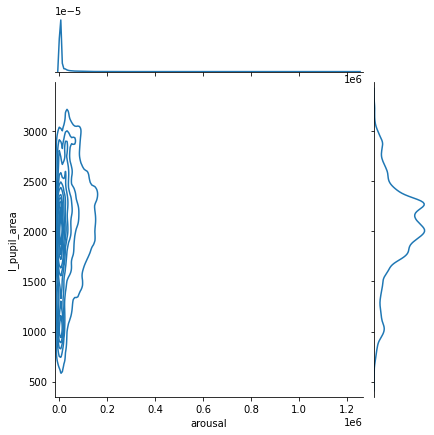

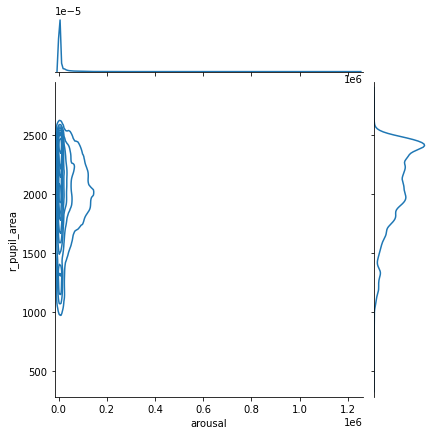

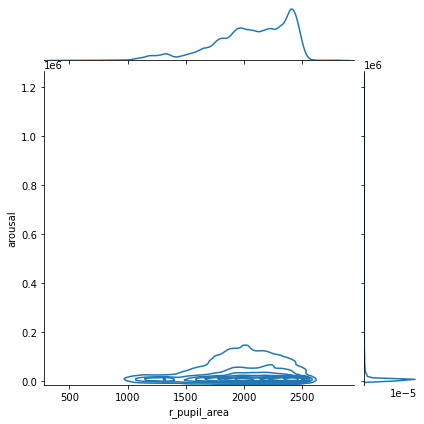

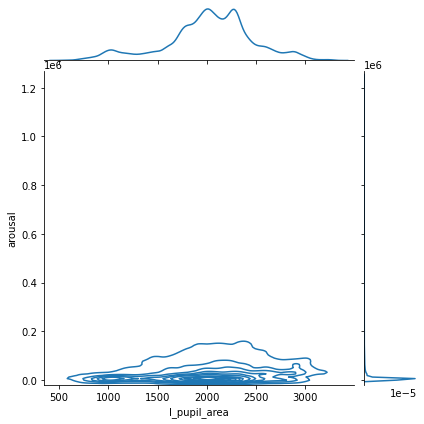

In [310]:

sns.jointplot(data=big_arousal_pupil_df,x='arousal',y='l_pupil_area',kind='kde')

sns.jointplot(data=big_arousal_pupil_df,x='arousal',y='r_pupil_area',kind='kde')

sns.jointplot(data=big_arousal_pupil_df,x='r_pupil_area',y='arousal',kind='kde')
sns.jointplot(data=big_arousal_pupil_df,x='l_pupil_area',y='arousal',kind='kde')

C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'aspect'
  cset = contour_func(


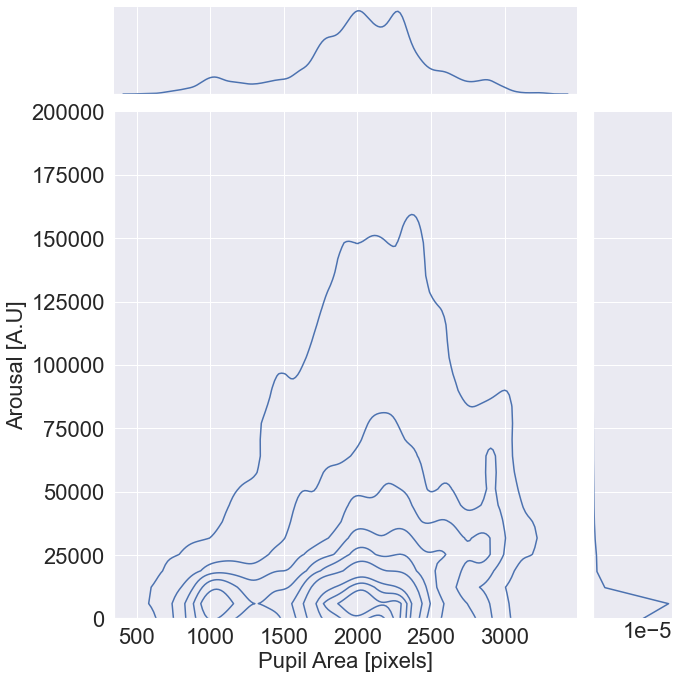

In [324]:


h = sns.jointplot(data=big_arousal_pupil_df,x='l_pupil_area',y='arousal',kind='kde',height=10,aspect=1,ylim=(0,200000))
h.set_axis_labels('Pupil Area [pixels]', 'Arousal [A.U]', fontsize=22)

plt.savefig(rf'D:\MarkS3\Pictures\Graphs\research_proposal\arousalVsPupilDiameter_LeftEye.png')

#sns.jointplot(data=big_arousal_pupil_df,x='l_pupil_area',y='arousal',kind='kde',height=10,aspect=1,ylim=(0,200000))
#g.ax_joint.set_yscale('log')


In [331]:
# Create saccade frequency graph

block = blockdict['012']
b_saccades = all_sync_df.query('block == "012"')
# loop over Arena_TTLs to create a mean saccade rate per 5 seconds
win_length = block.sample_rate * 20
step = block.sample_rate
ttls = block.final_sync_df.Arena_TTL.values
mean_saccade_rates = []
mean_saccade_timestamps = []
i = ttls[0]
while i < ttls[-1]:
    window = [i, i+win_length]
    saccades = len(all_sync_df.query('timestamps > @window[0] and timestamps < @window[1]')) # count saccades
    mean_saccade_timestamps.append((i + i+win_length)//2)
    mean_saccade_rates.append(saccades / 20)
    i += step #advance by one second



Text(0.5, 0.98, 'Saccade frequency trace')

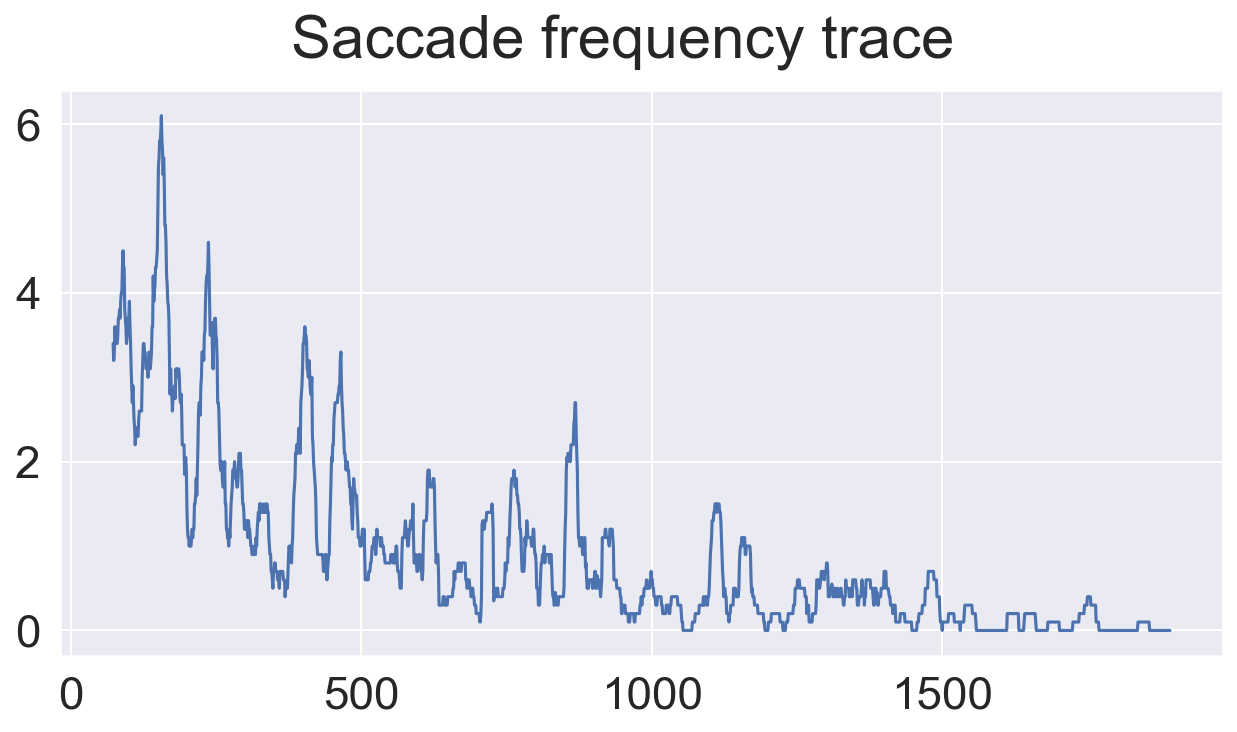

In [332]:
fig,ax = plt.subplots(figsize=(10,5),dpi=150)
sns.lineplot(x=np.array(mean_saccade_timestamps) //20000, y=mean_saccade_rates)
fig.suptitle('Saccade frequency trace')



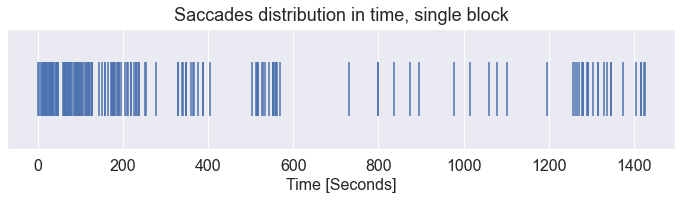

In [503]:
# Create saccade raster plot
from matplotlib.ticker import FormatStrFormatter
block = blockdict['012']
b_saccades = all_sync_df.query('block == "012" and eye =="L"')
saccade_times_ms = b_saccades['timestamps'].values - b_saccades['timestamps'].iloc[0]

fig, ax = plt.subplots(figsize=(10,3))
fig.suptitle('Saccades distribution in time, single block', fontsize=18)
ax.eventplot(saccade_times_ms /20000,)
ax.set_xlabel('Time [Seconds]',fontsize=16)
ax.ticklabel_format(style='plain')
ax.tick_params(labelsize=16)
#ax.set_xticks([])
_ = ax.set_yticks([])
plt.tight_layout()
plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\research_proposal\Saccades_RasterPlot_Block_12.png')

In [486]:
saccade_times_ms

array([0.0, 52194.0, 159308.0, 205699.0, 265740.0, 268128.0, 273929.0,
       333630.0, 335676.0, 370817.0, 378663.0, 380028.0, 384463.0,
       405274.0, 433589.0, 457126.0, 541052.0, 546512.0, 576197.0,
       579609.0, 582338.0, 614751.0, 616116.0, 627033.0, 651599.0,
       652622.0, 671386.0, 675138.0, 677867.0, 681961.0, 688784.0,
       695607.0, 712664.0, 713687.0, 722558.0, 812961.0, 845374.0,
       892453.0, 903712.0, 922473.0, 938167.0, 940555.0, 1178001.0,
       1234281.0, 1241102.0, 1242467.0, 1249631.0, 1283061.0, 1326043.0,
       1345488.0, 1390862.0, 1412358.0, 1454663.0, 1457392.0, 1479905.0,
       1481269.0, 1531067.0, 1582231.0, 1617705.0, 1709114.0, 1743567.0,
       1744931.0, 1746295.0, 1748001.0, 1749365.0, 1818945.0, 1819968.0,
       1827130.0, 1858170.0, 1869086.0, 1870109.0, 1903877.0, 1915816.0,
       1916839.0, 1921615.0, 1922638.0, 1931848.0, 1939693.0, 1953677.0,
       1964251.0, 1993587.0, 1995293.0, 2008937.0, 2068624.0, 2105464.0,
       2178453.

In [188]:
# Create pupil diameter and saccade frequency here:
L_pupil_col = []
R_pupil_col = []
for i in tqdm(range(len(all_sync_df))):
    block = blockdict[all_sync_df.iloc[i]['block']]
    timestamp = all_sync_df.iloc[i]['timestamps']
    L_pupil_col.append(block.le_df.query('Arena_TTL == @timestamp')['ellipse_size'].values)
    R_pupil_col.append(block.re_df.query('Arena_TTL == @timestamp')['ellipse_size'].values)
all_sync_df['l_pupil_size'] = np.vstack(L_pupil_col)
all_sync_df['r_pupil_size'] = np.vstack(R_pupil_col)

100%|██████████| 2126/2126 [00:05<00:00, 364.51it/s]


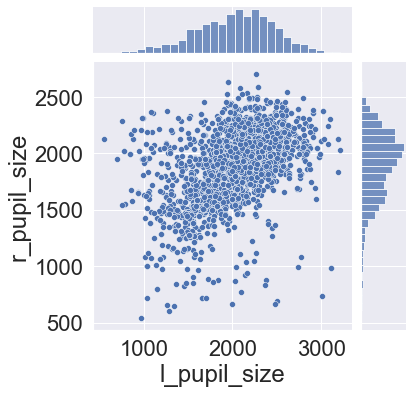

In [333]:
import seaborn as sns
sns.jointplot(x=all_sync_df['l_pupil_size'],y=all_sync_df['r_pupil_size'])

<ipython-input-489-8f6ac9d47a89>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  int_df = all_sync_df[non_sync_df['eye'] == 'L']
<ipython-input-489-8f6ac9d47a89>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  intervals = np.hstack(np.array(intervals_collection))


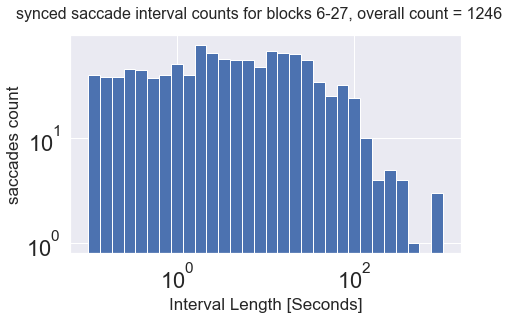

In [489]:
# Create Interval plots here

int_df = all_sync_df[non_sync_df['eye'] == 'L']
intervals_collection = []
for b in np.unique(int_df['block'].values):
    bdf = int_df.query('block == @b')
    #print(f'block {b} has {len(bdf)} synchornized saccades')
    intervals = np.diff(bdf['timestamps'].values / 20000)
    intervals_collection.append(intervals)
intervals = np.hstack(np.array(intervals_collection))
# intervals = intervals[intervals > 0.1]
# intervals = intervals[intervals < 1000]
fig,ax = plt.subplots(figsize=(7,4))
bins = np.geomspace(0.1,1000,31)
bin_sizes = bins[1:] - bins[:-1]
counts, _ = np.histogram(intervals,bins=bins)
bins_repeated = np.repeat(bin_sizes, counts)

#ax.hist(intervals,bins=bins[:-1],log=True,rwidth=1, weights=np.ones_like(intervals) / bins_repeated)
ax.hist(intervals,bins=bins,log=True,rwidth=1, density=False)
fig.suptitle(f'synced saccade interval counts for blocks 6-27, overall count = {len(intervals)}',fontsize=16)
ax.set_xlabel('Interval Length [Seconds]')
ax.set_xscale('log')
ax.set_ylabel('saccades count')
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)
#plt.savefig(fname=r'D:\MarkS3\Pictures\Graphs\research_proposal\synced_saccade_interval_counts_for_blocks_6_27_final.png')


In [444]:
bins = np.geomspace(0.1,1000,31)
bin_sizes = bins[1:] - bins[:-1]
counts, _ = np.histogram(intervals,bins=bins)
bins_repeated = np.repeat(bin_sizes, counts)

In [445]:
len(bins_repeated) == len(intervals)

True

<ipython-input-375-2b2836480295>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  intervals = np.hstack(np.array(intervals_collection))


<BarContainer object of 29 artists>

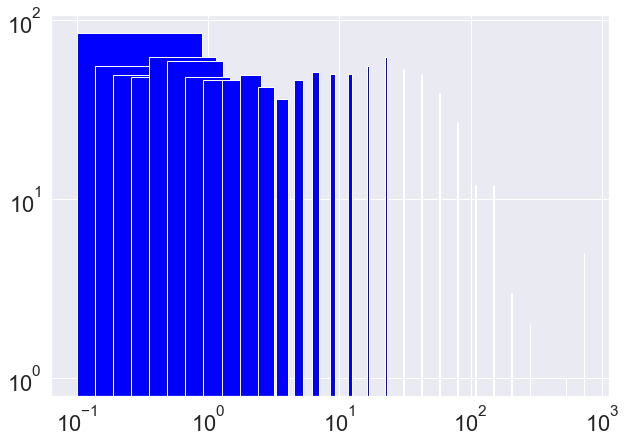

In [375]:
# Create Interval plots here

int_df = non_sync_df[non_sync_df['eye'] == 'L']
intervals_collection = []
for b in np.unique(int_df['block'].values):
    bdf = int_df.query('block == @b')
    #print(f'block {b} has {len(bdf)} synchornized saccades')
    intervals = np.diff(bdf['timestamps'].values / 20000)
    intervals_collection.append(intervals)
intervals = np.hstack(np.array(intervals_collection))

hist_data, bin_edges = np.histogram(intervals,bins=np.geomspace(0.1,1000,30))
fig, ax = plt.subplots(figsize=(10,7))
ax.set_xscale('log')
ax.bar(bin_edges[:-1], hist_data, log=True, align='edge', color='blue')

In [355]:
bin_edges

array([0.1       , 0.10826367, 0.11721023, 0.1268961 , 0.13738238,
       0.14873521, 0.1610262 , 0.17433288, 0.18873918, 0.20433597,
       0.22122163, 0.23950266, 0.25929438, 0.28072162, 0.30391954,
       0.32903446, 0.35622479, 0.38566204, 0.41753189, 0.45203537,
       0.48939009, 0.52983169, 0.57361525, 0.62101694, 0.67233575,
       0.72789538, 0.78804628, 0.85316785, 0.92367086, 1.        ])

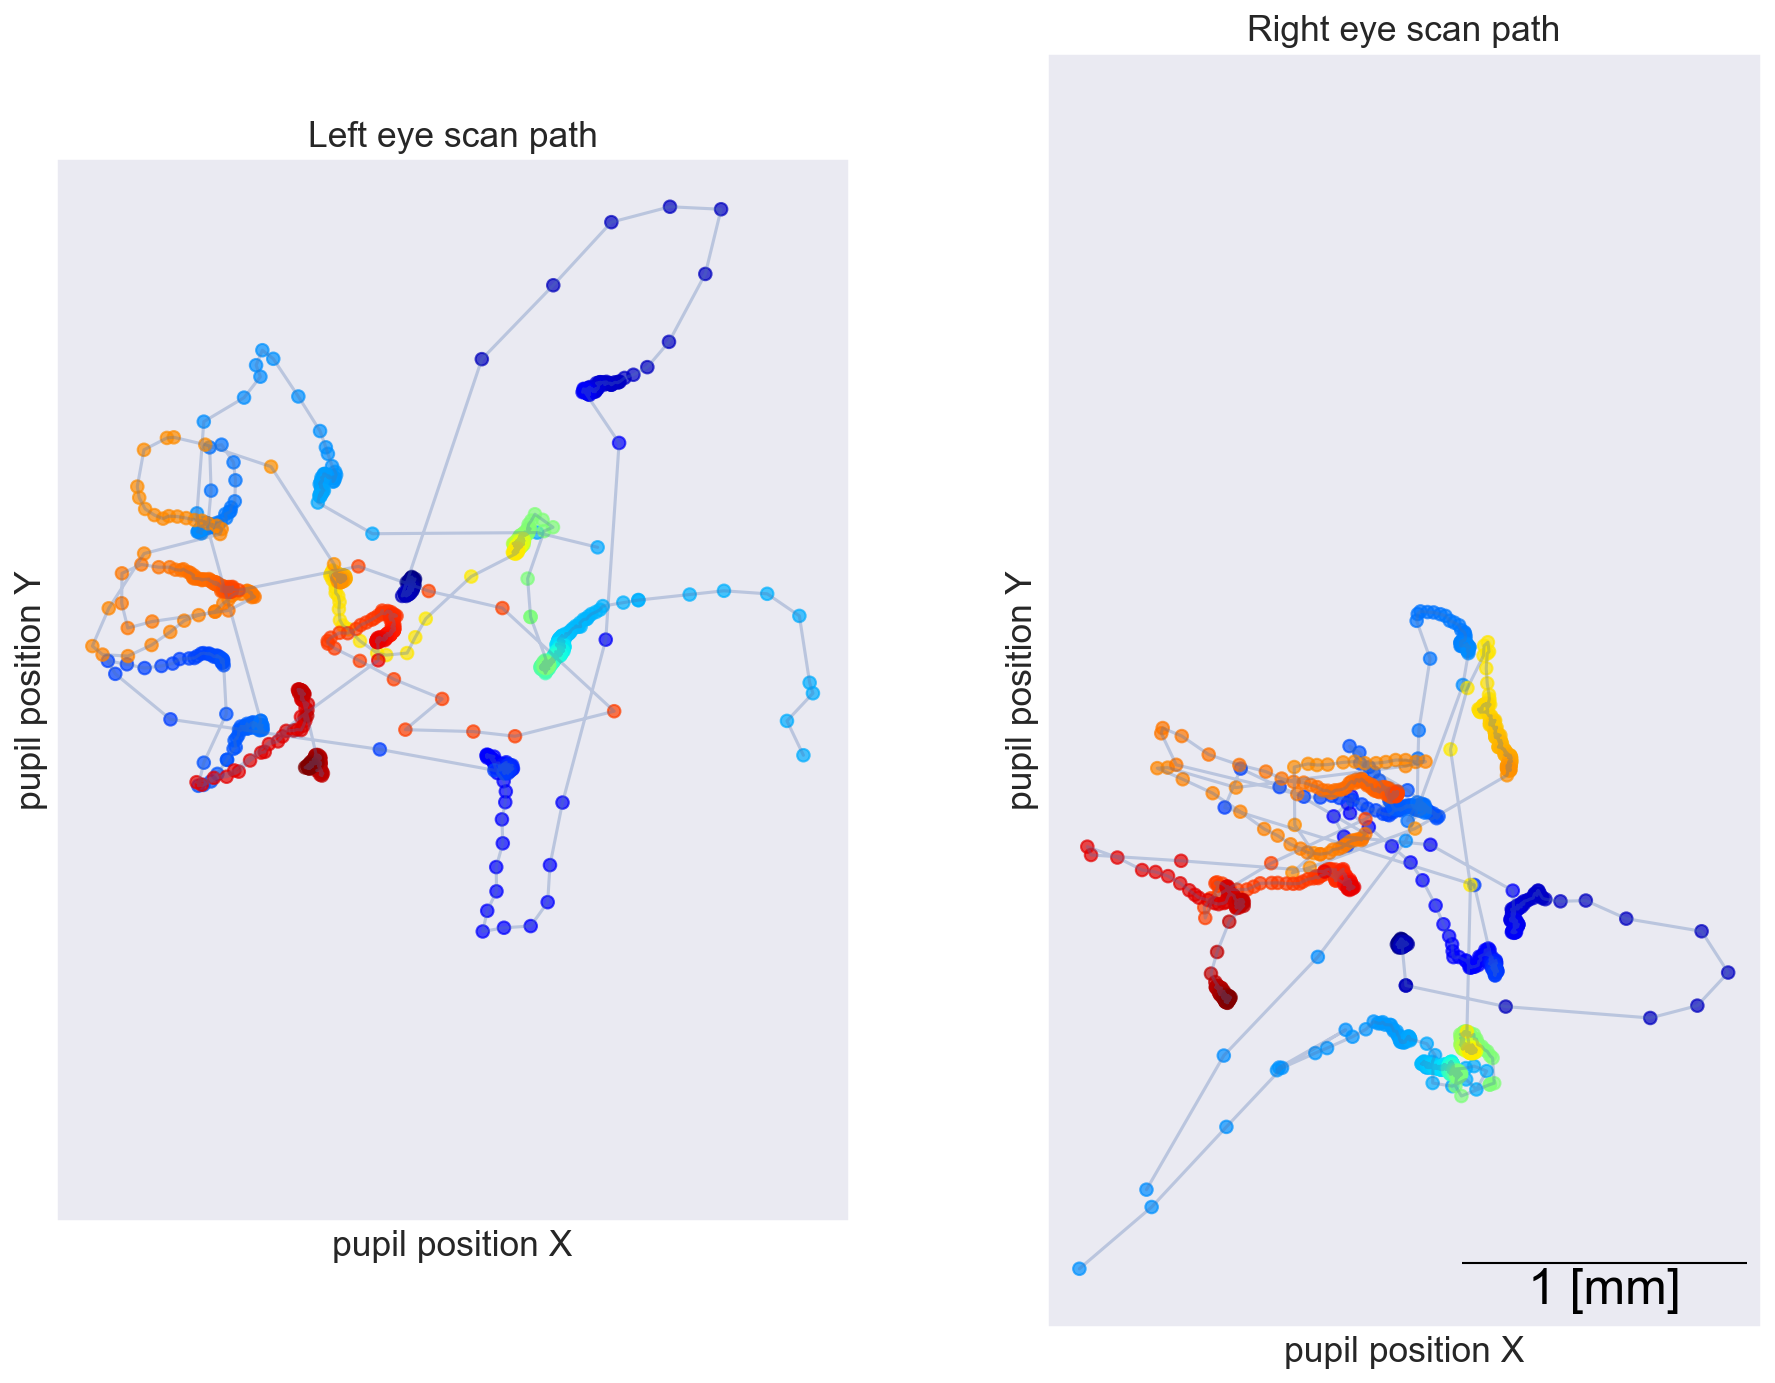

In [454]:
# define the block to work with
block = blockdict['012']
# define time segment in block
seg_starts = 40000
segment_ms = [seg_starts,seg_starts + 30000]
# plot L/R scan paths in mm
lcdf = block.le_df.query('ms_axis > @segment_ms[0] and ms_axis < @segment_ms[1]')
lx_coords = lcdf['center_x'] * block.L_pix_size
ly_coords = lcdf['center_y'] * block.L_pix_size
ltimestamps = lcdf['ms_axis']
rcdf = block.re_df.query('ms_axis > @segment_ms[0] and ms_axis < @segment_ms[1]')
rx_coords = rcdf['center_x'] * block.R_pix_size
ry_coords = rcdf['center_y'] * block.R_pix_size
rtimestamps = rcdf['ms_axis']

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
fig, ax = plt.subplots(1,2,figsize=(15,1.5*15*0.5),dpi=150, sharex='col', sharey='row',subplot_kw={'aspect': 1})
sp = ax[0].scatter(lx_coords,ly_coords,c=(ltimestamps.values - ltimestamps.values[0])/ 1000,cmap='jet',alpha=0.7, label='Left eye')
ax[0].plot(lx_coords,ly_coords,alpha=0.3)
#ax[0].set_aspect('equal','box')
ax[0].set_xlabel('pupil position X')
ax[0].set_ylabel('pupil position Y')
ax[0].set_title('Left eye scan path',fontsize=17)
#cb = plt.colorbar(sp,shrink=0.4)
#cb.set_label(label='Time [seconds]',fontsize=15)
bar = AnchoredSizeBar(ax[0].transData, 1, '1 [mm]', 4, borderpad=0.2, frameon=False)
ax[0].add_artist(bar)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].xaxis.label.set_size(17)
ax[0].yaxis.label.set_size(17)


ax[1].scatter(rx_coords,ry_coords,c=(rtimestamps.values - rtimestamps.values[0]) / 1000,cmap='jet',alpha=0.7, label='Right eye')
ax[1].plot(rx_coords,ry_coords,alpha=0.3)
ax[1].set_aspect('equal','box')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
bar = AnchoredSizeBar(ax[1].transData, 1, '1 [mm]', 4, borderpad=0.2, frameon=False)
ax[1].add_artist(bar)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Right eye scan path',fontsize=17)
ax[1].set_xlabel('pupil position X')
ax[1].set_ylabel('pupil position Y')
ax[1].xaxis.label.set_size(17)
ax[1].yaxis.label.set_size(17)
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\research_proposal\ScanPath_eyes_only_40To70Seconds_block12.png')

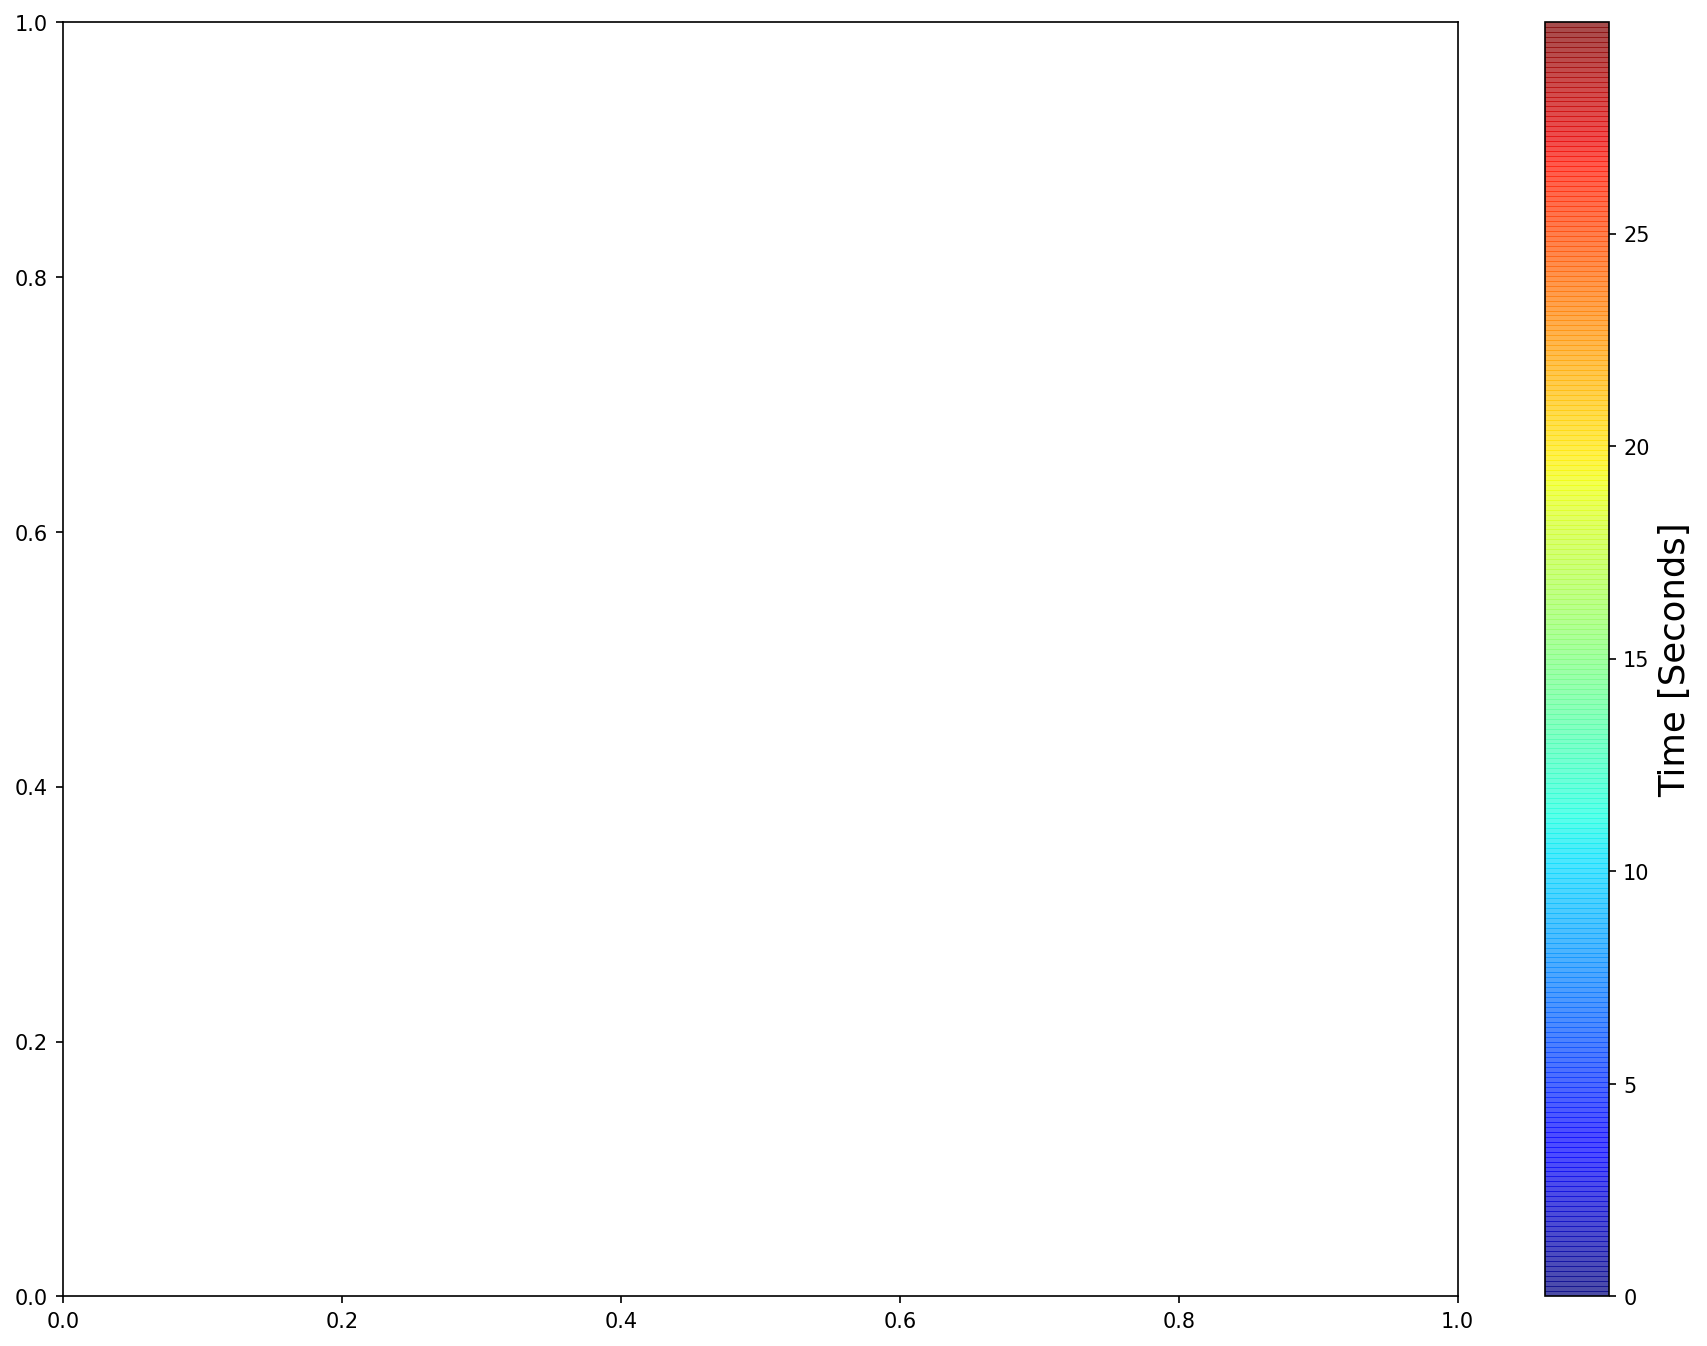

In [141]:
# This creates the colorbar without distorting the edges of the above figure
fig,ax = plt.subplots(figsize=(15,1.5*15*0.5),dpi=150)
cb = plt.colorbar(sp,shrink=1)
cb.set_label(label='Time [Seconds]',fontsize=17)
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\research_proposal\ScanPath_eyes_only_40To70Seconds_block12_COLORBAR.png')

KDE plots creation (given the loaded saccades dataframes created via EyeMovementsVsEP.ipynb

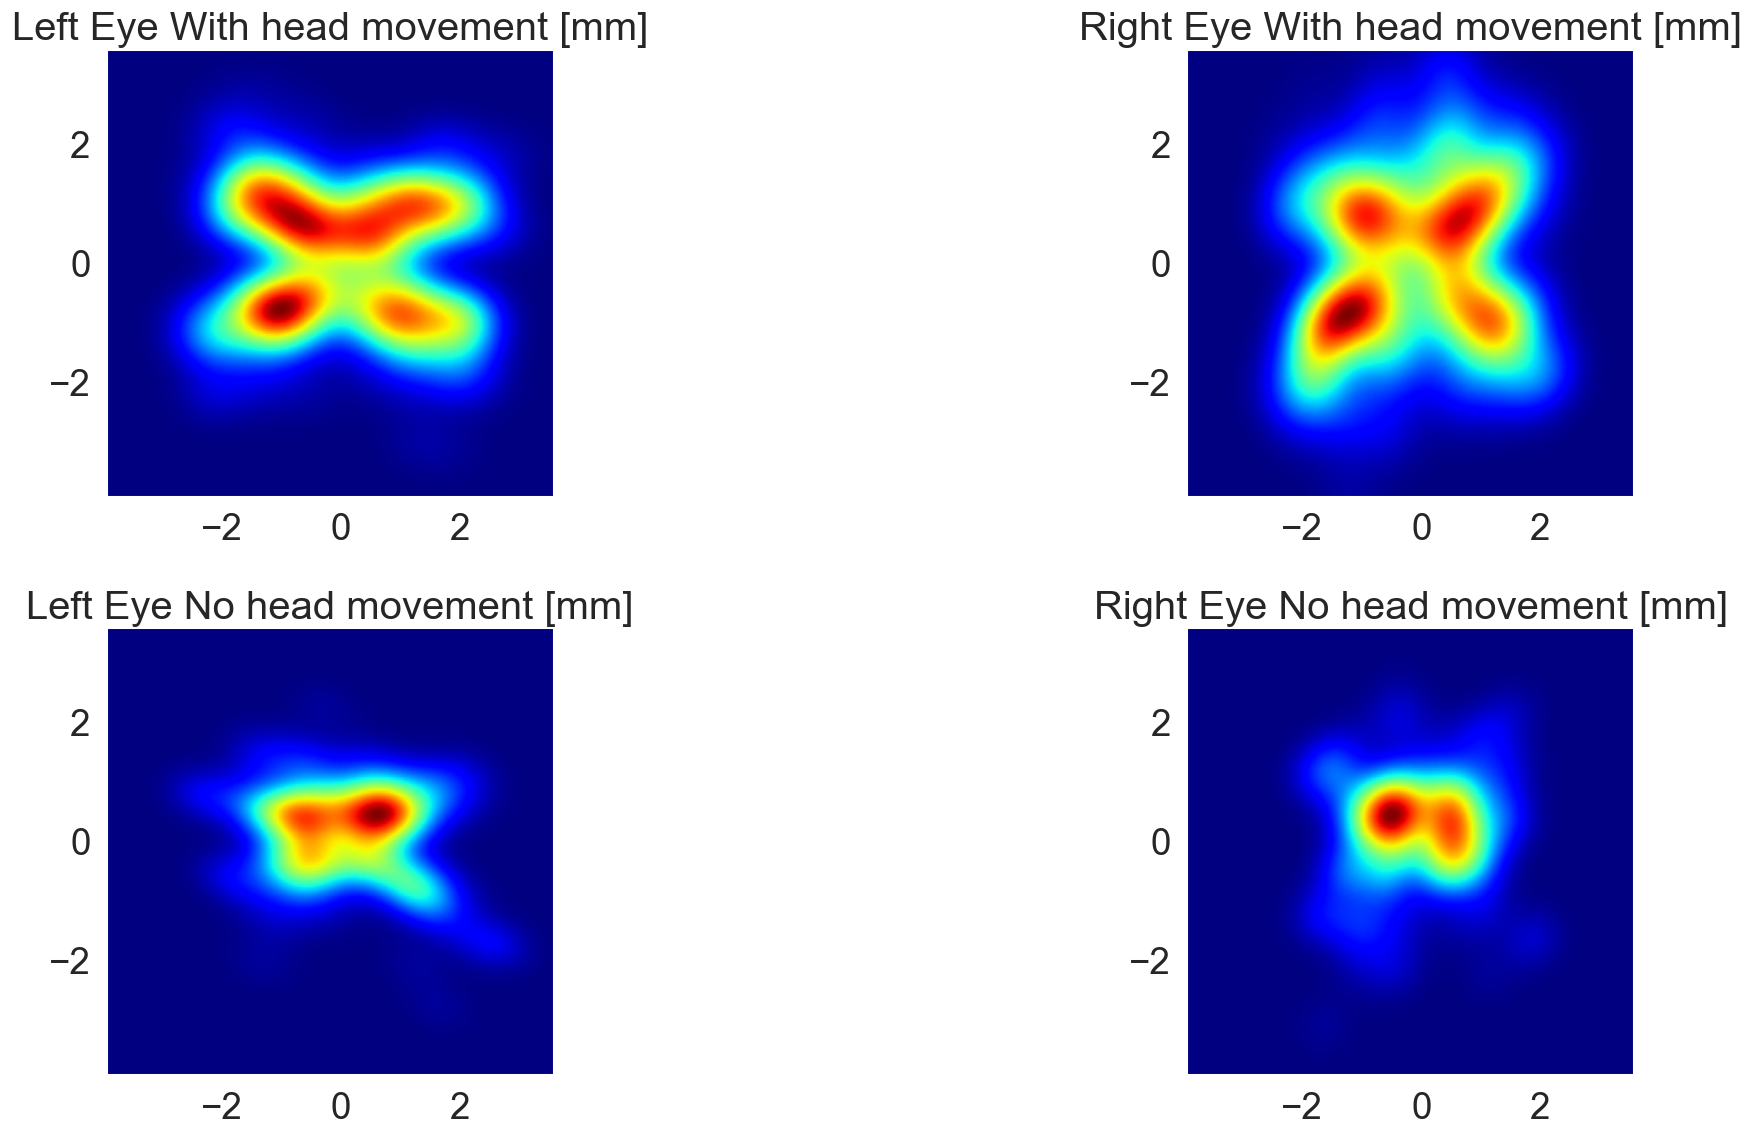

In [507]:
# This cell both defines and runs the kde based saccade direction and magnitude graph
def plot_kde(ax, x, y, nbins, title, xlim=False, ylim=False, global_max=None, global_min=None):
    k = kde.gaussian_kde(np.array([x,y]).astype(np.float))

    if global_max and global_min:
        minimal_coordinate= global_min
        maximal_coordinate = global_max
    else:
        minimal_coordinate= min([x.min(),y.min()])
        maximal_coordinate = max([x.max(),y.max()])
    xi, yi = np.mgrid[minimal_coordinate:maximal_coordinate:nbins*1j, minimal_coordinate:maximal_coordinate:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    ax.set_title(str(title))
    sp = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_aspect('equal','box')
    return sp

#id_list=['012']
id_list = blockdict.keys()
single_df = all_sync_df.query("block.isin(@id_list)")

# I can now query the data I want to analyze, let's take all the 0 accel magnitude saccades:
no_accel_df = single_df.query("accel == 0")
all_accel_df = single_df.query("accel != 0")

# I can produce the KDE graphs for them:
# parse queries:
la_x = all_accel_df.query('eye == "L"')['calib_dx']
la_y = all_accel_df.query('eye == "L"')['calib_dy']
ra_y = all_accel_df.query('eye == "R"')['calib_dy']
ra_x = all_accel_df.query('eye == "R"')['calib_dx']

ln_x = no_accel_df.query('eye == "L"')['calib_dx']
ln_y = no_accel_df.query('eye == "L"')['calib_dy']
rn_y = no_accel_df.query('eye == "R"')['calib_dy']
rn_x = no_accel_df.query('eye == "R"')['calib_dx']

#understand graph bounderies:
x_stack = np.concatenate([la_x,ra_x,ln_x,rn_x])
y_stack = np.concatenate([la_y,ra_y,ln_y,rn_y])
global_max = np.max(np.concatenate([x_stack,y_stack]))
global_min = np.min(np.concatenate([x_stack,y_stack]))

#xlim = (np.min(x_stack), np.max(x_stack))
#ylim = (np.min(y_stack), np.max(y_stack))

# create the graph
fig, axes = plt.subplots(ncols=2, nrows=2, figsize =(10*2,5*2), dpi=120)
plot_kde(axes[0,0],la_x,la_y,200,'Left Eye With head movement [mm]',global_max=global_max,global_min=global_min)
plot_kde(axes[0,1],ra_x,ra_y,200,'Right Eye With head movement [mm]',global_max=global_max,global_min=global_min)
plot_kde(axes[1,0],ln_x,ln_y,200,'Left Eye No head movement [mm]',global_max=global_max,global_min=global_min)
plot_kde(axes[1,1],rn_x,rn_y,200,'Right Eye No head movement [mm]',global_max=global_max,global_min=global_min)
#fig.suptitle(f"Movment Saccades Count = {len(all_accel_df)} \n No movement Saccade Count = {len(no_accel_df)}")
fig.tight_layout()
#plt.savefig(rf'D:\MarkS3\Pictures\Graphs\research_proposal\saccade_heatmaps.png')
